# Deep Learning Aplicado a la Detección Automática de Valvulopatías Usando Sonidos Cardíacos
John Jairo Gelpud Chachinoy<sup>1</sup>, Silvia Gabriela Castillo Pastuzan<sup>2</sup>

Director: PhD. Wilson O. Achicanoy Martínez<sup>3</sup>

Coasesor: PhD(c). Mario Fernando Jojoa<sup>4</sup>

<sup>1</sup>Departamento de Electrónica, Universidad de Nariño, Pasto, e-mail: johnjairog@udenar.edu.co

<sup>2</sup>Departamento de Electrónica, Universidad de Nariño, Pasto, e-mail:gabrielacast@udenar.edu.co

<sup>3</sup>Departamento de Electrónica, Universidad de Nariño, Pasto, e-mail:wilachic@udenar.edu.co

<sup>4</sup>Universidad de Deusto, España, e-mail:mariojojoa@deusto.es


# Introducción
El presente código hace parte de los documentos desarrollados como parte del trabajo de tesis de grado para optar por el título de Ingeniero Electrónico en la Universidad de Nariño. En este documento se describen todas las etapas implementadas para entrenar algoritmos de Deep Learning, en específico redes neuronales convolucionales (CNN), junto con la técnica de transfer learning para la clasificación de sonidos cardíacos en las categorias normal y anormal.

## Código de Inicialización

### Importar Librerías
El siguiente código importa todas las librerías necesarias para ejecutar el programa.

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import zipfile
import io
import scikitplot as skplt
import random
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix

plt.style.use('seaborn-white')
plt.rcParams.update({'font.size':18})

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Cargar Datos
El conjunto de datos que se va a utilizar para entrenar y evaluar los modelos de Deep Learning debe tener la estructura que se muestra en la Fig. 1.

![Figure 1](dataset.svg)
**Figura 1 | Estructura del conjunto de datos.**

El conjunto de datos se puede cargar de dos formas dependiendo del entorno en el que se esté trabajando.

- **Google Colab.** Si el código se está ejecutando en Google Colab el conjunto de datos debe ser un archivo comprimido zip que contenga las carpetas: "train", "val", y "test". En cada subconjunto de datos deben haber dos carpetas, una para cada categoria.
- **Sistema local.** Si el código se está ejecutando localmente se debe especificar el directorio donde se encuentran los subconjuntos "train", "val", y "test".

In [2]:
# Si se está ejecutando en Google Colab definir colab=True
colab = False
# Si se está ejecutando localmente especificar el directorio en dataset_path
dataset_path = 'D:/UDENAR/Electronic Engineering/Projects/CardioDeep2/Results/v.1.0/Classification/Teager/Datasets/'

if colab:
    dataset_path = ''
    from google.colab import files
    uploaded = files.upload()
    data = zipfile.ZipFile(io.BytesIO(uploaded['Datasets.zip']), 'r')
    data.extractall()
else:
    print('Ejecutando en sistema local')

Ejecutando en sistema local


In [3]:
# Normalización de las imágenes para la etapa de entrenamiento y validación
data_transforms = {
    'train':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test':transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Crea los datasets y dataloaders con un batch de 4 imágenes, y aplica las transformaciones
image_datasets = {x: datasets.ImageFolder(dataset_path+x, data_transforms[x])
                      for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True,
                                              num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes # nombres de las categorias
# Selecciona la GPU o CPU como dispositivo para realizar las operaciones y
# almacenar variables
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Visualización de Escalogramas 
Muestra algunas imágenes del conjunto de datos con su respectiva etiqueta.

In [5]:
def imshow(inp, title=None):
    # Visualiza un batch de imágenes
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 15))
    plt.imshow(inp, aspect='equal')
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pausar para actualizar las figuras

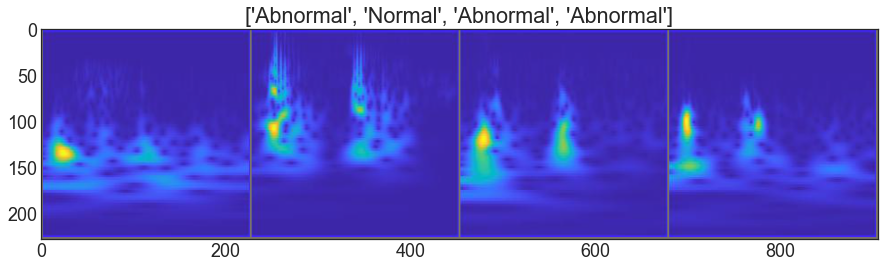

In [6]:
# Toma un batch de imágenes de entrenamiento
inputs, classes = next(iter(dataloaders['train']))
# Construye una malla a partir del batch de imágenes
out = torchvision.utils.make_grid(inputs)
# Visualiza las imágenes
imshow(out, title=[class_names[x] for x in classes])

## Entrenamiento de los modelos
### Funciones de entrenamiento y visualización
Las siguientes funciones permiten entrenar un modelo de Deep Learning y visualizar las predicciones hechas por el modelo entrenado para algunas imágenes.

In [7]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    # Entrena un modelo de Deep Learning utilizando los hiperparámetros indicados y devuelve el 
    # modelo que obtuvo la mayor exactitud durante el entrenamiento.
    since = time.time() # devuelve la hora actual
    best_model_wts = copy.deepcopy(model.state_dict()) # copia del modelo
    best_acc = 0.0 # almacena la mejor exactitud alcanzada
    training_cost = [] # almacena los valores de pérdida en la etapa de entrenamiento
    training_acc = [] # almacena los valores de exactitud en la etapa de entrenamiento
    validation_cost = [] # almacena los valores de pérdida en la etapa de validación
    validation_acc = [] # almacena los valores de exactitud en la etapa de validación
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        # Cada época tiene una etapa de entrenamiento y de validación
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # configurar el modelo en modo de entrenamiento
            else:
                model.eval()   # configurar el modelo en modo de evaluación
            running_loss = 0.0
            running_corrects = 0
            
            # Iterar sobre los datos de entrenamiento
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # mueve los tensores a la GPU o CPU
                labels = labels.to(device) # mueve los tensores a la GPU o CPU
                # Reinicia el gradiente
                optimizer.zero_grad()
                
                # Forward
                # Habilita los gradientes solo en la fase de entrenamiento
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # salidas del modelo
                    _, preds = torch.max(outputs, 1) # predicciones del modelo
                    loss = criterion(outputs, labels) # pérdida o error del modelo
                    
                    # Propagación hacia atrás del error y optimización del modelo
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Estadísticas
                running_loss += loss.item() # error acumulado
                running_corrects += torch.sum(preds == labels.data) # predicciones correctas acumuladas
                
            if phase == 'train': # etapa de entrenamiento 
                scheduler.step() # actualiza la taza de aprendizaje
                training_cost.append(running_loss) # guarda el error acumulado
                training_acc.append(running_corrects.double().cpu()/dataset_sizes[phase]) # guarda la exactitud
                # obtenida
            else: # etapa de validación
                validation_cost.append(running_loss) # guarda el error acumulado
                validation_acc.append(running_corrects.double().cpu()/dataset_sizes[phase]) # guarda la 
                # exactitud obtenida
                
            epoch_loss = running_loss
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')
            
            # Guarda el modelo que obtuvo la mejor exactitud con los datos de validación
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since # tiempo de entrenamiento
    print(f'Training complete in {time_elapsed//60}m {time_elapsed%60}s')
    print(f'Best val Acc: {best_acc}')
    # Carga los pesos del mejor modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_cost, training_acc, validation_cost, validation_acc

In [8]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    # Visualiza las predicciones del modelo y las etiquetas reales de algunas imágenes
    was_training = model.training
    model.eval()
    images_so_far = 0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'pred: {class_names[preds[j]]} / real: {class_names[labels[j]]}')
                img = torch.movedim(inputs.cpu().data[j], 0, 2)*std+mean
                ax.imshow(torch.clip(img, 0, 1))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

### Ajuste de las Redes Neuronales Convolucionales
Para que los algoritmos de inteligencia artificial sean capaces de detectar anomalías cardíacas a partir de las imágenes de escalogramas, es necesario extraer las características más importantes y que proporcionan la mayor cantidad de información acerca de la actividad cardíaca de un paciente, es por esto que se hace uso de las redes neuronales convolucionales. Una red neuronal convolucional es un modelo de Deep Learning ampliamente utilizado en tareas visuales complejas, incluyendo la clasificación y segmentación de imágenes, y la detección de objetos. La arquitectura típica de una red neuronal convolucional se muestra en la Fig. 2, esta posee multiples capas convolucionales y de max pooling, en la etapa de extracción de características; seguidas por una o más capas totalmente conectadas, en la etapa de clasificación.

![Figure 2](cnn.jpg)
**Figura 2|Arquitectura básica de una red neuronal convolucional** Disponible en: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

Por lo general, para crear y entrenar desde cero un modelo clasificador de imágenes se necesita una enorme cantidad de datos y mucho tiempo de entrenamiento para alcanzar un desempeño aceptable en la tarea de clasificación, sin contar la gran cantidad de hiperparámetros del modelo que se pueden modificar. Es por esto que, en la práctica, se utilizan modelos de redes convolucionales preentrenadas para posteriormente ajustar sus pesos utilizando un conjunto de datos reducido. Esta técnica se conoce como Transfer Learning (ver Fig. 3), y tienes las ventajas de reducir el tiempo de entrenamiento y la cantidad de datos de entrenamiento necesarios para alcanzar una buena exactitud.

![Figure 3](transfer_learning.svg)
**Figura 1 | Transfer Learning.** Disponible en: https://www.datasciencecentral.com/transfer-learning-deep-learning-for-everyone/

Los redes preentrenadas escogidas para llevar a cabo la tarea de clasificación fueron: ResNet152 y VGG16. El 60% de los datos se utilizó para la etapa de entrenamiento, 20% para la etapa validación, y 20% en la prueba de los modelos. Las redes se entrenaron durante 25 épocas, usando un optimizador basado en el gradiente descendente estocástico con momento de 0.9 y una tasa de aprendizaje de 0.001, la cual se reduce por un factor de 0.1 cada 7 épocas. 

#### ResNet152
Es una red neuronal convolucional bastante profunda compuesta de 152 capas que usa conexiones o atajos entre capas de diferentes niveles. 

In [9]:
# Define los hiperpárametros de la CNN ResNet152
res_model = models.resnet152(pretrained=True) # carga el modelo preentrenado
num_ftrs = res_model.fc.in_features # número de características extraídas por el modelo
res_model.fc = nn.Linear(num_ftrs, 2) # modifica la última capa del modelo para obtener
# una clasificación binaria
res_model = res_model.to(device) # envía el modelo a la GPU o CPU
criterion = nn.CrossEntropyLoss() # función de pérdida
optimizer = optim.SGD(res_model.parameters(), lr=0.001, momentum=0.9) # optimizador
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # reduce la
# tasa de aprendizaje cada 7 épocas de entrenamiento

In [10]:
# Define la cantidad de épocas y ajusta el modelo
num_epochs = 25
res_model, train_cost, train_acc, val_cost, val_acc = train_model(res_model, criterion, optimizer,
                                                                  exp_lr_scheduler, dataloaders,
                                                                  dataset_sizes, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 235.1998634338379 Acc: 0.6938925680647535
val Loss: 86.46159957416967 Acc: 0.847682119205298

Epoch 1/24
----------
train Loss: 175.64690485410392 Acc: 0.7880794701986755
val Loss: 49.69759539197548 Acc: 0.869757174392936

Epoch 2/24
----------
train Loss: 141.88698968058452 Acc: 0.8366445916114791
val Loss: 120.26988484663889 Acc: 0.5055187637969095

Epoch 3/24
----------
train Loss: 104.90132488618838 Acc: 0.8859455481972038
val Loss: 42.6141225945903 Acc: 0.8830022075055187

Epoch 4/24
----------
train Loss: 90.25940551096573 Acc: 0.9094922737306843
val Loss: 37.53055673907511 Acc: 0.8653421633554084

Epoch 5/24
----------
train Loss: 52.24988635524642 Acc: 0.9551140544518028
val Loss: 34.61165229677863 Acc: 0.9028697571743929

Epoch 6/24
----------
train Loss: 24.609351141290972 Acc: 0.9764532744665195
val Loss: 36.61942955624545 Acc: 0.9006622516556292

Epoch 7/24
----------
train Loss: 19.111528921261197 Acc: 0.9845474613686535
val Loss: 32.15258

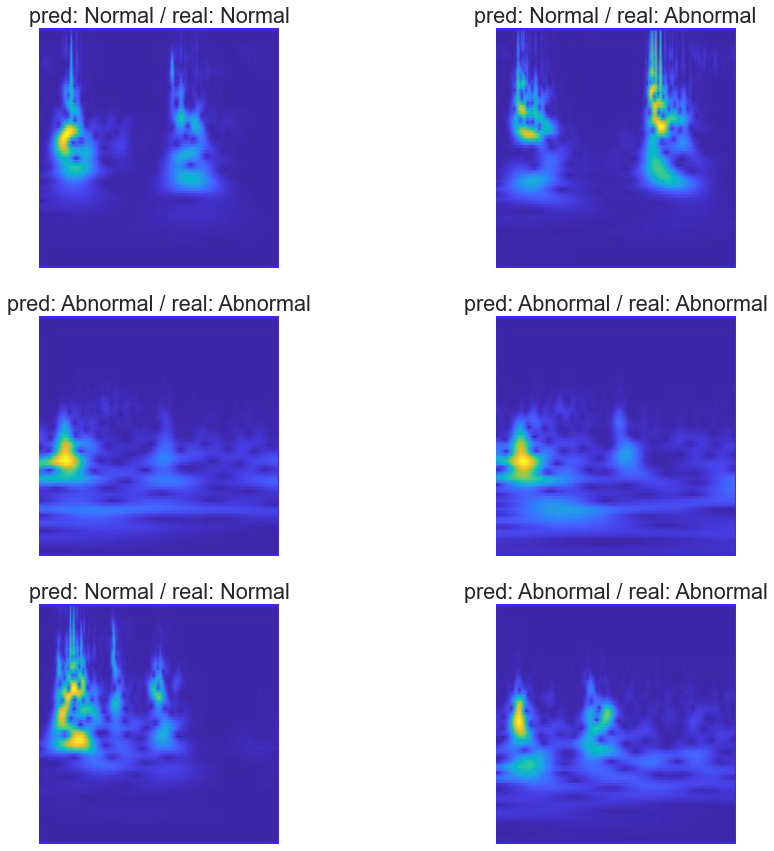

In [11]:
# Muestra las predicciones del modelo para algunas imágenes de validación
visualize_model(res_model, dataloaders, class_names)
plt.ioff()
plt.show()

#### VGG16
Esta red neuronal convolucional está compuesta de 13 capas convolucionales y 3 capas totalmente conectadas.

In [12]:
# Define los hiperparámetros de la CNN VGG16
vgg_model = models.vgg16(pretrained=True) # obtiene el modelo preentrenado
num_ftrs = vgg_model.classifier[6].in_features # número de características extraídas por
# el modelo
vgg_model.classifier[6] = nn.Linear(num_ftrs, 2) # modifica la última capa del modelo para
# obtener una una clasificación binaria
vgg_model = vgg_model.to(device) # envía el modelo a la GPU o CPU
criterion = nn.CrossEntropyLoss() # función de pérdida
optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9) # optimizador
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # reduce la tasa 
# de aprendizaje cada 7 épocas

In [13]:
# Define la cantidad de épocas y ajusta el modelo
num_epochs = 25
vgg_model, vgg_train_cost, vgg_train_acc, vgg_val_cost, vgg_val_acc = train_model(vgg_model, criterion, optimizer, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=num_epochs)

Epoch 0/24
----------
train Loss: 204.69731691479683 Acc: 0.6961000735835173
val Loss: 57.60476793348789 Acc: 0.7924944812362031

Epoch 1/24
----------
train Loss: 166.52513898350298 Acc: 0.7829286239882266
val Loss: 50.52349322102964 Acc: 0.8233995584988962

Epoch 2/24
----------
train Loss: 154.70487447734922 Acc: 0.8145695364238411
val Loss: 42.30306504294276 Acc: 0.8432671081677704

Epoch 3/24
----------
train Loss: 123.69752921536565 Acc: 0.8454746136865342
val Loss: 42.24978797882795 Acc: 0.8565121412803532

Epoch 4/24
----------
train Loss: 110.28980450006202 Acc: 0.8631346578366446
val Loss: 36.961052030324936 Acc: 0.8609271523178808

Epoch 5/24
----------
train Loss: 89.2023035701568 Acc: 0.8903605592347315
val Loss: 37.528843017295 Acc: 0.8653421633554084

Epoch 6/24
----------
train Loss: 74.4598393249471 Acc: 0.9109639440765268
val Loss: 35.85335712693632 Acc: 0.8763796909492274

Epoch 7/24
----------
train Loss: 35.008195485163014 Acc: 0.9683590875643856
val Loss: 34.18107

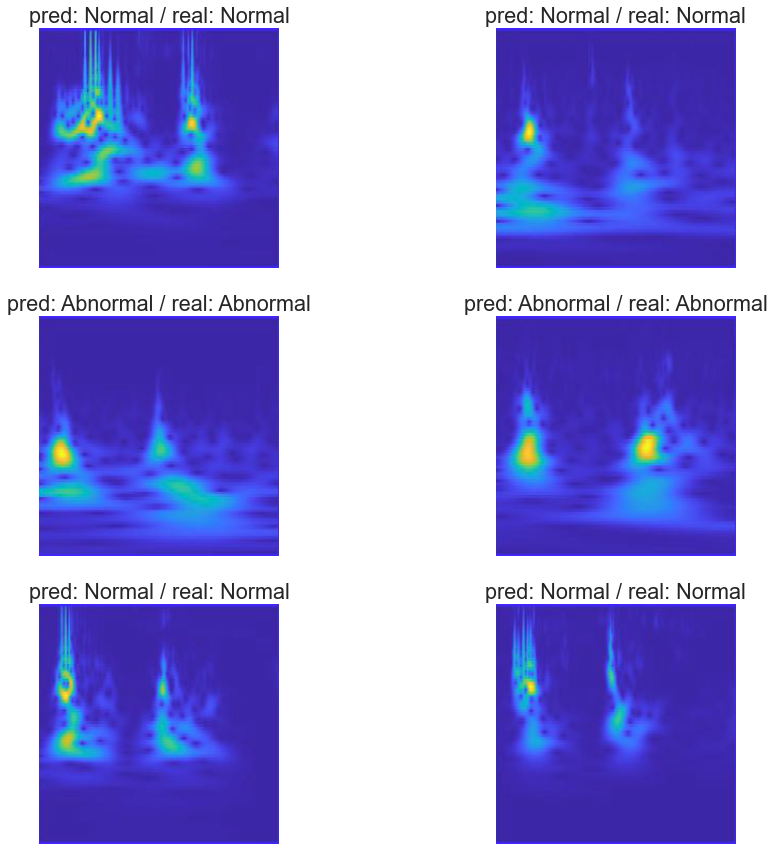

In [14]:
# Muestra las predicciones del modelo para algunas imágenes de validación
visualize_model(vgg_model, dataloaders, class_names)

### Curvas de aprendizaje
El siguiente código muestra las curvas de aprendizaje de los modelos, incluyendo los valores de pérdida y exactitud en cada época.

In [15]:
def plot_learning_curves(train_loss, train_acc, val_loss, val_acc, image_type, epochs):
    # Visualiza las curvas de aprendizaje del modelo
    fig, ax = plt.subplots(2, 1, sharex='all', figsize=(10, 8))
    x = range(0, epochs)
    ax[0].set_title('Curvas de aprendizaje para la '+image_type)
    ax[0].plot(x, train_loss, '-+', label='training loss')
    ax[0].plot(x, val_loss, '-+', label='validation loss')
    ax[0].set_ylabel('loss')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].plot(x, train_acc, '-+', label='training accuracy')
    ax[1].plot(x, val_acc, '-+', label='validation accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].grid(True)
    ax[1].legend()
    plt.show()

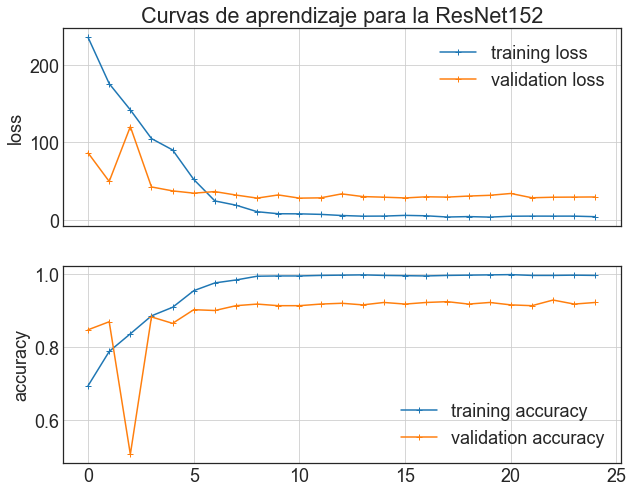

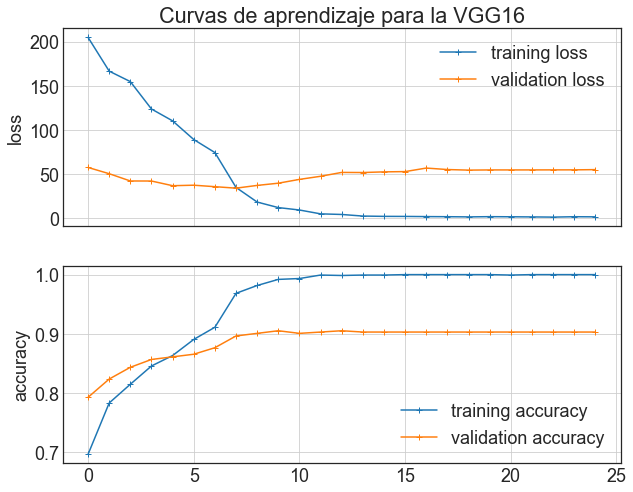

In [16]:
# Visualizar curvas de aprendizaje
plot_learning_curves(train_cost, train_acc, val_cost, val_acc, 'ResNet152', num_epochs)
plot_learning_curves(vgg_train_cost, vgg_train_acc, vgg_val_cost, vgg_val_acc, 'VGG16', num_epochs)

## Evaluación de los modelos
Utiliza los datos de prueba para evaluar los modelos ajustados y obtener sus medidas de rendimiento, incluyendo la exactitud, la sensitividad, la especificidad y precisión.

In [17]:
def get_performance_measures(models, dataloader, dataset_sizes, class_names):
    # Mide el rendimiento de los modelos ajustados
    accuracy_scores = {'ResNet152':0, 'VGG16':0}
    sensitivity_scores = {'ResNet152':0, 'VGG16':0}
    specificity_scores = {'ResNet152':0, 'VGG16':0}
    precision_scores = {'ResNet152':0, 'VGG16':0}
    
    for model, cnn_type, i in zip(models, ['ResNet152', 'VGG16'], range(2)):
        pred_labels = [] # guarda las predicciones del modelo
        test_labels = [] # guarda las etiquetas de las imágenes de prueba
        running_corrects = 0
        
        # Iterar sobre los datos de prueba
        for inputs, labels in dataloader['test']:
            inputs = inputs.to(device) # mueve los tensores a la GPU o CPU
            labels = labels.to(device) # mueve los tensores a la GPU o CPU
            outputs = model(inputs) # salidas del modelo
            _, preds = torch.max(outputs, 1) # predicciones del modelo
            running_corrects += torch.sum(preds==labels.data) # predicciones correctas acumuladas
            p = np.array(preds.cpu())
            l = np.array(labels.cpu())
            
            for x in range(p.size):
                pred_labels.append(p.item(x)) # guarda las predicciones del modelo
                test_labels.append(l.item(x))
                
        # Calcula las metricas de rendimiento del modelo
        skplt.metrics.plot_confusion_matrix(test_labels, pred_labels, title=cnn_type,
                                            normalize=False) # visualiza la matriz de confusión
        plt.show()
        test_acc = running_corrects.double()/dataset_sizes['test'] # exactitud
        accuracy_scores[cnn_type] = test_acc.cpu().data
        precision_scores[cnn_type] = precision_score(test_labels, pred_labels, pos_label=0) # precisión
        sensitivity_scores[cnn_type] = recall_score(test_labels, pred_labels, pos_label=0) # sensitividad
        specificity_scores[cnn_type] = recall_score(test_labels, pred_labels, pos_label=1) #especificidad
        
    print(f'accuracy: {accuracy_scores}')
    print(f'precision: {precision_scores}')
    print(f'sensitivity: {sensitivity_scores}')
    print(f'specificity: {specificity_scores}')
    plt.figure(figsize=(10, 12))
    plt.subplot(221)
    plt.bar(accuracy_scores.keys(), accuracy_scores.values())
    plt.ylabel('accuracy')
    plt.title('accuracy on test set')
    plt.grid(True)
    plt.subplot(222)
    plt.bar(precision_scores.keys(), precision_scores.values())
    plt.ylabel('precision')
    plt.title('precision on test set')
    plt.grid(True)
    plt.subplot(223)
    plt.bar(sensitivity_scores.keys(), sensitivity_scores.values())
    plt.ylabel('sensitivity')
    plt.title('sensitivity on test set')
    plt.grid(True)
    plt.subplot(224)
    plt.bar(specificity_scores.keys(), specificity_scores.values())
    plt.ylabel('specificity')
    plt.title('specificity on test set')
    plt.grid(True)
    plt.show()
    
    return pred_labels, test_labels

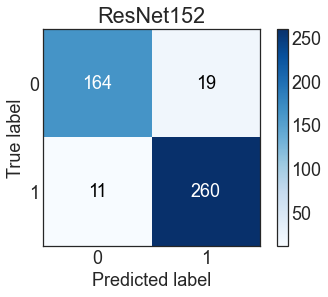

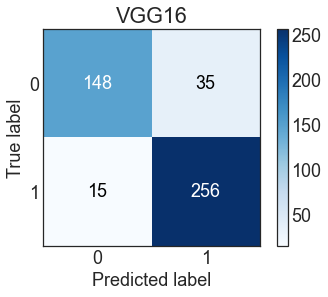

accuracy: {'ResNet152': tensor(0.9339, dtype=torch.float64), 'VGG16': tensor(0.8899, dtype=torch.float64)}
precision: {'ResNet152': 0.9371428571428572, 'VGG16': 0.9079754601226994}
sensitivity: {'ResNet152': 0.8961748633879781, 'VGG16': 0.8087431693989071}
specificity: {'ResNet152': 0.959409594095941, 'VGG16': 0.9446494464944649}


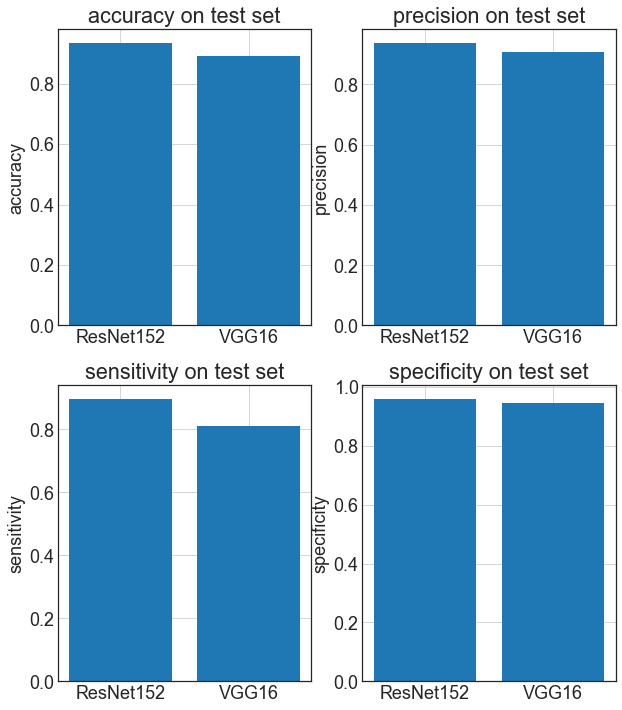

In [18]:
models = [res_model, vgg_model]
pred, test = get_performance_measures(models, dataloaders, dataset_sizes, class_names)

# References
1. S. Chilamkurthy, “TRANSFER LEARNING FOR COMPUTER VISION TUTORIAL.” https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html (accessed Feb. 14, 2022).
2. Géron, A.: Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems (2019). https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/
3. Gelpud J., Castillo S., Jojoa M., Garcia-Zapirain B., Achicanoy W., Rodrigo D. (2021) Deep Learning for Heart Sounds Classification Using Scalograms and Automatic Segmentation of PCG Signals. In: Rojas I., Joya G., Català A. (eds) Advances in Computational Intelligence. IWANN 2021. Lecture Notes in Computer Science, vol 12861. Springer, Cham. https://doi.org/10.1007/978-3-030-85030-2_48